In [1]:
# !pip install haystack-ai
# !pip install "datasets>=2.6.1"
# !pip install "sentence-transformers>=2.2.0"
# !pip install -U transformers
# !pip install accelerate

In [2]:
import json
with open('./data/Деятельность.json') as f:
    files = json.load(f)

In [3]:
files[1]

{'url': 'https://cbr.ru/cash_circulation/',
 'title': 'Наличное денежное обращение',
 'text': 'Навигация по разделу:БанкнотыМодернизация банкнотПамятные банкнотыМонетыПамятные и инвестиционные монетыОрганизация работы с денежной наличностьюВидеоматериалыСпециальные краски, предназначенные для предотвращения хищения банкнот Банка России при их транспортировке и храненииМобильное приложение «Банкноты Банка России»СтатистикаАналитикаПравовые актыВопросы и ответыНовостиЭмиссия наличных денег и организация их оборота — функция центральных банков, которая появилась раньше всех остальных. В соответствии со статьей 75 Конституции Российской Федерации денежная единица Российской Федерации — рубль, а денежная эмиссия осуществляется исключительно Банком России.Согласно статье 30 Федерального закона от 10 июля 2002 года №86-ФЗ«О Центральном банке Российской Федерации (Банке России)» банкноты и монета являются безусловными обязательствами Банка России и обеспечиваются всеми его активами.Банкноты и 

In [4]:
from haystack import Document
import glob

In [5]:
docs = []
json_files = glob.glob("./data/*.json")
for file_path in json_files:
    with open(file_path) as f:
        files = json.load(f)
    for file in files:
        docs.append(
            Document(content=file["text"], meta={"title": file["title"], "url": file["url"]})
        )    

In [6]:
len(docs)

463

In [7]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
document_store = InMemoryDocumentStore()  # policy = DuplicatePolicy.SKIP

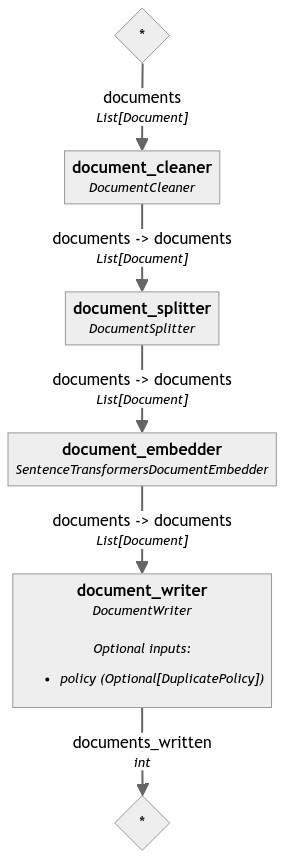

In [8]:
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.preprocessors.document_cleaner import DocumentCleaner
from haystack import Pipeline
from haystack.utils import ComponentDevice

document_cleaner = DocumentCleaner(
    remove_empty_lines=True,
	remove_extra_whitespaces=True,
	remove_repeated_substrings=False
)
document_splitter = DocumentSplitter(split_by="word", split_length=100, split_overlap=10)
document_embedder = SentenceTransformersDocumentEmbedder(
    # model="BAAI/bge-small-en-v1.5", 
    model="intfloat/multilingual-e5-large",
    meta_fields_to_embed=["title"], 
    device=ComponentDevice.from_str("cuda:0")
)
document_writer = DocumentWriter(document_store, policy = DuplicatePolicy.SKIP)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("document_cleaner", document_cleaner)
indexing_pipeline.add_component("document_splitter", document_splitter)
indexing_pipeline.add_component("document_embedder", document_embedder)
indexing_pipeline.add_component("document_writer", document_writer)

indexing_pipeline.connect("document_cleaner", "document_splitter")
indexing_pipeline.connect("document_splitter", "document_embedder")
indexing_pipeline.connect("document_embedder", "document_writer")

In [9]:
# indexing_pipeline.run({"document_cleaner": {"documents": docs[:len(docs)//2]}})

indexing_pipeline.run({"document_cleaner": {"documents": docs}})

Batches:   0%|          | 0/591 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
len(document_store.storage.keys())

12682

In [11]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(
    # model="BAAI/bge-small-en-v1.5", 
    model="intfloat/multilingual-e5-large",
    device=ComponentDevice.from_str("cuda:0")
)
embedding_retriever = InMemoryEmbeddingRetriever(document_store)
bm25_retriever = InMemoryBM25Retriever(document_store)

In [12]:
from haystack.components.joiners import DocumentJoiner

document_joiner = DocumentJoiner(join_mode='reciprocal_rank_fusion', top_k=10)

In [13]:
from haystack.components.rankers import TransformersSimilarityRanker, LostInTheMiddleRanker

# ranker = TransformersSimilarityRanker(model="BAAI/bge-reranker-base")
lost_in_the_middle_ranker = LostInTheMiddleRanker(word_count_threshold=1024, top_k=10)

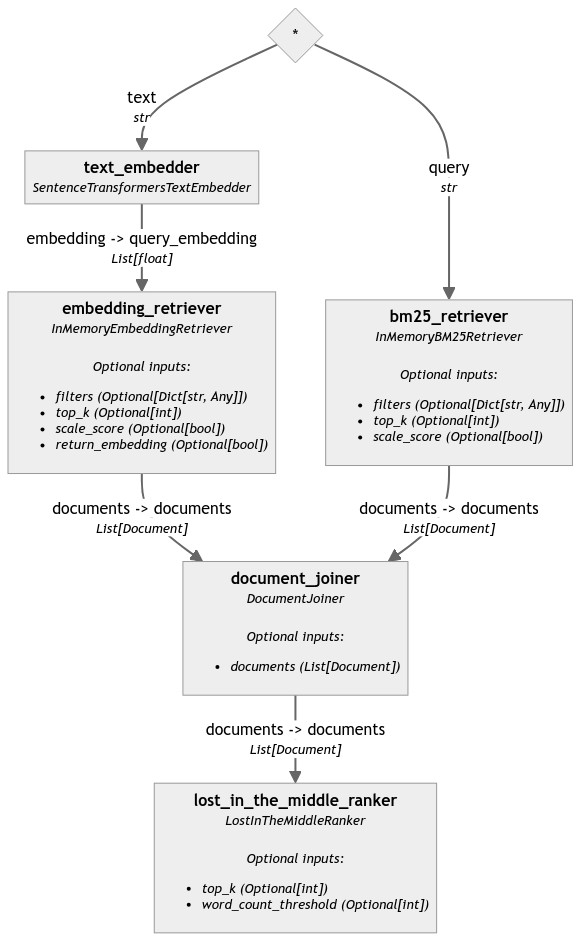

In [14]:
from haystack import Pipeline

hybrid_retrieval = Pipeline()
hybrid_retrieval.add_component("text_embedder", text_embedder)
hybrid_retrieval.add_component("embedding_retriever", embedding_retriever)
hybrid_retrieval.add_component("bm25_retriever", bm25_retriever)
hybrid_retrieval.add_component("document_joiner", document_joiner)
# hybrid_retrieval.add_component("ranker", ranker)
hybrid_retrieval.add_component("lost_in_the_middle_ranker", lost_in_the_middle_ranker)

hybrid_retrieval.connect("text_embedder", "embedding_retriever")
hybrid_retrieval.connect("bm25_retriever", "document_joiner")
hybrid_retrieval.connect("embedding_retriever", "document_joiner")
hybrid_retrieval.connect("document_joiner", "lost_in_the_middle_ranker")
# hybrid_retrieval.connect("document_joiner", "ranker")
# hybrid_retrieval.connect("ranker", "lost_in_the_middle_ranker")

In [15]:
hybrid_retrieval.draw("hybrid-retrieval.png")

In [16]:
def pretty_print_results(prediction):
    for doc in prediction["documents"]:
        print(doc.meta["title"], "\t", doc.meta["url"], "\t", doc.score)
        print(doc.content)
        print("\n", "\n")

In [17]:
# indexing_pipeline.run({"document_cleaner": {"documents": docs[len(docs)//2:]}})
# len(document_store.storage.keys())

In [18]:
query = "Могу ли я внести в кредитную историю родственника информацию о неисполнении им уже имеющихся обязательств"
# query = "информацию о неисполнении обязательств в кредитную историю родственника"
result = hybrid_retrieval.run(
    {"text_embedder": {"text": query}, "bm25_retriever": {"query": query}}  # "ranker": {"query": query}
)

pretty_print_results(result["lost_in_the_middle_ranker"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ranking by BM25...:   0%|          | 0/12682 [00:00<?, ? docs/s]

Вопросы и ответы 	 https://cbr.ru/ckki/faq_ckki/ 	 1.0
помогаете нам стать лучше!11Могу ли я внести в кредитную историю родственника информацию о неисполнении им уже имеющихся обязательств, чтобы ему больше не выдавали кредиты?Обновлено: 21.06.2022Внесение сведений в кредитную историю родственника невозможно.В соответствии с пунктом 4 статьи 3Закона о кредитных историяхинформацию о заемщике — субъекте кредитной истории (субъект) передает в бюро кредитных историй (БКИ) источник формирования кредитной истории (как правило, кредитор, например, банк).При этом опекун (попечитель) физического лица — субъекта, признанного на основании решения суда недееспособным или ограниченно дееспособным, а также иной законный представитель такого физического лица в соответствии с законодательством Российской Федерации вправе обратиться с заявлением в БКИ или к 

 

Вопросы и ответы 	 https://cbr.ru/ckki/faq_ckki/ 	 0.4841269841269841
информация о котором подлежит передаче в бюро кредитных историй, без сог

In [19]:
help_information = ''
sources = []
for doc in result["lost_in_the_middle_ranker"]["documents"]:
    source = 'Заголовок: ' + doc.meta["title"] + ", URL: " + doc.meta["url"] + ", Score: " + str(doc.score)
    sources.append(source)
    help_information+="Источник: " + source  + '\n'
    help_information+="Текст: " + doc.content+'\n'

In [20]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

MODEL_NAME = "IlyaGusev/saiga_mistral_7b"
DEFAULT_MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
DEFAULT_RESPONSE_TEMPLATE = "<s>bot\n"
DEFAULT_SYSTEM_PROMPT = "Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."

class Conversation:
    def __init__(
        self,
        message_template=DEFAULT_MESSAGE_TEMPLATE,
        system_prompt=DEFAULT_SYSTEM_PROMPT,
        response_template=DEFAULT_RESPONSE_TEMPLATE
    ):
        self.message_template = message_template
        self.response_template = response_template
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += DEFAULT_RESPONSE_TEMPLATE
        return final_text.strip()


def generate(model, tokenizer, prompt, generation_config):
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(
        **data,
        generation_config=generation_config
    )[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output.strip()

config = PeftConfig.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    # load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto"
)
model = PeftModel.from_pretrained(
    model,
    MODEL_NAME,
    torch_dtype=torch.float16
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
query

'Могу ли я внести в кредитную историю родственника информацию о неисполнении им уже имеющихся обязательств'

In [22]:
%%time
# query = ''
# help_information = ''

inp = f"Ответь на вопрос: {query} \n Используй вспомогательную информацию: {help_information}"
conversation = Conversation()
conversation.add_user_message(inp)
prompt = conversation.get_prompt(tokenizer)

output = generate(model, tokenizer, prompt, generation_config) + f'\n\nИсточники ответа: \n{sources}'
# print(inp)
print(output)

Вы не можете внести в кредитную историю родственника, так как это противоречит законодательству. Кредитная история является частной информацией, и внесение в нее данных о третьих лицах без их согласия является незаконным.

Источники ответа: 
['Заголовок: Вопросы и ответы, URL: https://cbr.ru/ckki/faq_ckki/, Score: 1.0', 'Заголовок: Вопросы и ответы, URL: https://cbr.ru/ckki/faq_ckki/, Score: 0.4841269841269841', 'Заголовок: Вопросы и ответы, URL: https://cbr.ru/ckki/faq_ckki/, Score: 0.4765625', 'Заголовок: Вопросы и ответы, URL: https://cbr.ru/ckki/faq_ckki/, Score: 0.46923076923076923', 'Заголовок: Кредитные истории, URL: https://cbr.ru/faq/credit_h/, Score: 0.4621212121212121', 'Заголовок: Вопросы и ответы, URL: https://cbr.ru/ckki/faq_ckki/, Score: 0.4621212121212121', 'Заголовок: Кредитные истории, URL: https://cbr.ru/faq/credit_h/, Score: 0.46923076923076923', 'Заголовок: Формирование резервов на возможные потери по ссудам (Положение Банка России от 28.06.2017 № 590-П), URL: http